<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
ML Full-Stack Showcase
              
</p>
</div><br>
<h2>From Model Training to Deployment.</h2>
<br>

<p>Hosted by Aakash (<b>Kash</b>) Sudhakar and <b>Praveen</b> Gowtham.</p>
<br>
<br>
Coding Week September 2023

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.tokenize import word_tokenize # nltk's gold standard word tokenizer
from nltk.corpus import stopwords #used for removing tokens in english stopword list
from nltk.stem import SnowballStemmer # stemming for text normalization

from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier

import dill as pickle
import matplotlib.pyplot as plt


In [104]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prave\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Outline

#### Step 1: Data preprocessing, model training, and machine learning pipeline

- SMS Spam Classification
- Taken in free text, predict target class:
    - ham
    - spam
- Export text handling and prediction pipeline as single file

<center><img src = "images/modeling-pipeline/spamvsham.png" ></center>

#### Step 2: Model deployment: building front-end and back-end 

- Load **modeling pipeline** using Python backend
- Set up **"endpoint"** to access backend model from frontend web site
- Create **user email form** to trigger endpoint in React

<center><img src = "images/backend-server/flask-web-access-diagram.png" ></center>

### Loading data in:

In [24]:
sms_df = pd.read_csv('../data/spam.csv', encoding='latin')
sms_df = sms_df[['v1', 'v2']].rename(columns={'v1': 'target', 'v2': 'text'})
sms_df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Examples of ham vs spam SMS text messages in the dataset:

In [21]:
print(sms_df.iloc[10].text)

I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.


In [22]:
print(sms_df.iloc[12].text)

URGENT! You have won a 1 week FREE membership in our å£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18


A simple NLP workflow:

<img src = "images/modeling-pipeline/text_feature_pipe.png" >

### Input Preprocessing

We are going to be writing a simple **text input preprocessing pipeline**:

1. Define necessary text preprocessing functions
2. Wrap functions into scikit-learn transformer framework
3. Define vectorizer: final step before model training
4. Define preprocessing pipeline for data feeding.

### Defining necessary functions

Tokenization: split documents into semantic units

<img src = "images/processing-pipeline/tokenization.webp" >

In [1]:
def lowering_func(x):
    return x.str.lower()

def tokenizer(x, tokenizer):
    return x.apply(tokenizer)

Stemmers consolidate different forms of word by chopping off endings.
<center><img src = "Images/processing-pipeline/stemmer.png" width = 200> </center>

In [6]:
def text_normalizer(x, stopword_list):

    # use Snowballstemmer
    stemmer = SnowballStemmer('english')
 
    # remove numbers and punctuation
    # removes words that are extremely common in the english language 
    # apply stemmer
    sw_removed = \
    x.apply(lambda txt: 
            [stemmer.stem(elem) 
             for elem in txt if 
             ( (elem not in stopword_list) 
              & elem.isalpha() )  ] )

    return sw_removed

# rejoin to prepare for document input to vectorizer
def rejoiner(x):
    rejoined = x.str.join(" ")
    return rejoined


### Wrap functions into scikit-learn transformer framework


In [29]:
lower_text = FunctionTransformer(lowering_func)
apply_tokenizer = FunctionTransformer(tokenizer, kw_args={'tokenizer': word_tokenize} )
normalizer = FunctionTransformer(text_normalizer, kw_args={'stopword_list': stopwords.words('english') } )
stringjoin =  FunctionTransformer(rejoiner)

### Define vectorizer: final step before model training


Numerical vector representation of documents for feeding into classifier model.

<center><img src = "Images/processing-pipeline/vectorchart.png" ></center>

In [34]:
countvec = CountVectorizer(min_df = 0.01, max_df = 0.95)

### Define preprocessing pipeline for data feeding.


- **Pipeline** composes sequence of transformations and vectorization into a single object.
- Lot of advantages: 
    - packaging preprocessing in single entity
    - **modularity and extensibility**

In [33]:
nlp_preprocess_pipe = \
Pipeline([('lower', lower_text), 
          ('tokenizer', apply_tokenizer),
          ('textnorm', normalizer),
          ('join', stringjoin),
          ('vec', countvec) ])

Split into sms text and target (spam/ham):
- aim is to **learn relationship between these**

In [125]:
X = sms_df['text']
y = sms_df['target']

Split dataset into:
- portion for training model
- part set aside for evaluation/testing (**data model hasn't seen before**)

In [126]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3)

## Modeling

In the pipeline framework: 
- adding a final estimator step after preprocessing chain -- this will be our classifier
- **data transformation + predictive modeling in one combined estimator**

In [133]:
modeling_pipe = Pipeline([('preprocess', nlp_preprocess_pipe ), ('model', RandomForestClassifier())])

Fit entire pipeline on training data:

In [134]:
modeling_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('lower',
                                  FunctionTransformer(func=<function lowering_func at 0x0000019D40AA8790>)),
                                 ('tokenizer',
                                  FunctionTransformer(func=<function tokenizer at 0x0000019D40AA8A60>,
                                                      kw_args={'tokenizer': <function word_tokenize at 0x0000019D3B674040>})),
                                 ('textnorm',
                                  FunctionTransformer(func=<function text_normalizer at 0x0000019D4129A...
                                                                                 'ourselves',
                                                                                 'you',
                                                                                 "you're",
                                                                                 "you've",
                       

After model training, evaluate model on test data:
- get class predictions given test text inputs
- in practice, there is model tuning/validation (we won't cover this here)

In [135]:
y_pred = modeling_pipe.predict(X_test)
y_pred[0:10]

#### Model Evaluation
- Did our pipeline (data transformation + classifier) do a good job on the test set?

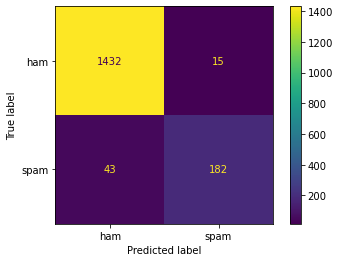

In [148]:
cfmat = confusion_matrix(y_test, y_pred)

ax = ConfusionMatrixDisplay(cfmat, display_labels = y.unique()).plot()

print(classification_report(y_test, y_pred))

This model is doing pretty well. 
- **Save trained model for deployment.**

In [153]:
pickle.dump(modeling_pipe, open('../saved_models/full_pipeline.pkl', 'wb'))

Next steps:
- Get out of the Jupyter notebook
- **Deploy pickled model** onto Flask server
- **Setup API endpoint** to server
- Create **frontend form** in React to invoke endpoint

## Backend Deployment

To create our Flask server, the major needed files are:
- The **pickled modeling pipeline** (`full_pipeline.pkl`)
- A Python script to **create and manage our server** (`app.py`)
- And an additional Python script to **"talk" to our model** (`services.py`)

<center><img src = "images/backend-server/backend-hierarchy-view.png" height=200></center>

### Setting up our server

We can write Python code to set up a "route" to a virtual server that'll be used to "serve" our saved model to a website.

<center><img src = "images/backend-server/flask-server-init-setup-route-code.png" ></center>

Once the server is launched, we can test it by checking its home page response:

<center><img src = "images/backend-server/flask-server-response-api.png" width=400></center>

### Setting up an API endpoint for our model

To allow our website to "talk" to our model, we need to set it up a specific way: as an **"API endpoint" that can be "served"** to any frontend. 

We can continue doing so in Python:

<center><img src = "images/backend-server/flask-model-classify-endpoint.png" width=600></center>

This endpoint will **"invoke" our model**, which will call a **special custom function** that performs the **text processing and classification logic** that we've already programmed in Jupyter.

<center><img src = "images/backend-server/flask-model-classify-service.png" width=600></center>

This is a little harder to test though – we need to actually "ping" it from a frontend. 

## Frontend Deployment

To create our React web app, the major needed files are:
- The **main application rendering file** (`App.jsx`)
- A rendering file for the **email submission form** (`ContactForm.jsx`)
- And a rendering file for the **response message** (`ResponseModal.jsx`)

<center><img src = "images/backend-server/frontend-hierarchy-view.png" height=400></center>

### Setting up our email form

The main frontend component of our website needs two parts: a **user-submittable form** and a way for **text data to be passed to our backend** and invoke our model for classification.

Let's tackle the second part first using a **FETCH request to the API endpoint** we established earlier:

<center><img src = "images/frontend-client/react-form-api-invocation.png" width=600></center>

Hardest part is over! 

Now it's just a matter of **writing our email form** so users can actually send text data:

<center><img src = "images/frontend-client/react-form-structure.png" width=700></center>

### Rendering a conditional response based on model prediction

Next, we have to send a **specific text response** based on whether our email is _ham_ or _spam_. 

<center><img src = "images/frontend-client/react-response-toggle-handle.png" width=1000></center>

### Putting it all together

With our **email form and conditional response files** created, we can tether them all together in our application and finally connect it to our backend.

<center><img src = "images/frontend-client/react-app-layout.png" width=800></center>

## Testing the web app

Time to see how we did! When we navigate to our web app, we should see the following:

<center><img src = "images/frontend-client/web-app-home-view.png" width=400></center>

If we send in a message that sounds like a standard email, we should get a normal response:

<center><img src = "images/frontend-client/web-app-ham-response.png" width=400></center>

But if we send a spam-like email, we should get a warning response in return!

<center><img src = "images/frontend-client/web-app-spam-response.png" width=1000></center>

Aaaaand that's it! We've successfully built a full-stack web app integrated with machine learning! :-)